# CONUS 404 diagnostic plots

### Input Data Access

- This notebook illustrates how to make diagnostic plots using the CONUS 404 dataset hosted on NCAR's glade storage.
- https://rda.ucar.edu/datasets/d559000/
- This data is open access and can be accessed via 3 protocols 1) posix (**if you access to NCAR's HPC**) 2) HTTPS (**from outside of NCAR**) 3) OSDF using an intake-ESM catalog.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import intake
import numpy as np
from pathlib import Path
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [3]:
# replace this directory with your own scratch space! 
rda_scratch = '/glade/derecho/scratch/kukulies'
cat_url     = '/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json'
print(cat_url)

/glade/campaign/collections/rda/data/d559000/catalogs/d559000_catalog.json


## Create a PBS cluster

**Why?** 

Dask can read and process multiple files at once — much faster than serial loading.
By creating a PBS cluster, we set up a Dask cluster that submits PBS batch jobs to run Dask workers on the HPC system.
Each worker uses 1 core and 8GB of RAM, and jobs are submitted to the 'casper' queue with a 5-hour time limit.
The workers will write temporary data and logs to the specified scratch directory (this should be your user scratch space /glade/derecho/scratch/**username**).

This process helps handling data larger than memory by breaking it into chunks and processing them lazily.

In [4]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext')

In [5]:
cluster.scale(5)

In [6]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kukulies/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.188:41147,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kukulies/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Look at the data on the glade system

You can see that the data is structured in water years (**wyYYYY**), where one water year starts in October and ends in September. 

In [7]:
conus_data = Path('/glade/campaign/collections/rda/data/d559000/')
# List subdirectories
subdirs = [p.name for p in conus_data.iterdir() if p.is_dir()]
print(subdirs)

['wy1987', 'wy1982', 'wy2010', 'wy2009', 'wy2005', 'wy2022', 'wy2001', 'wy2017', 'wy1999', 'wy1994', 'INVARIANT', 'wy2013', 'wy2008', 'wy1988', 'wy2003', 'wy2020', 'wy1983', 'wy2015', 'wy1980', 'wy2011', 'kerchunk', 'wy2006', 'wy1995', 'wy2002', 'wy1997', 'wy1990', 'wy2018', 'wy1992', 'wy2014', 'wy1989', 'wy1984', 'wy1986', 'wy1981', 'wy2004', 'wy2021', 'catalogs', 'wy2000', 'wy2016', 'wy2012', 'wy1996', 'wy1998', 'wy1991', 'wy2007', 'wy1993', 'wy2019', 'wy1985']


You can access the original WRF output files here, but the files are stored for each hour and contain many many variables. That is fine if you work only with one specific dataset, but could be inefficient and time-consuming, especially if you combine this data with multiple datasets. **This is where catlogues come into play. The catalogue allows you to...**

- **query data** based on variable, time, etc (without needing to know the actual filenames)
- **load the data efficiently** (not loading everything into memory if you only look for one specific variable but over a longer time period where the timesteps are stored in different files )
- **browse through the metadata** of different datasets without downloading or loading the actual data 

## Load CONUS 404 data from RDA using an intake catalog

In [8]:
col = intake.open_esm_datastore(cat_url)
col

,unique
path,79
variable,206
format,1
short_name,206
long_name,118
units,32
start_time,41
end_time,41
level,0
level_units,0


##### What variables are in the dataset? 

note that the keys are structured as *variable.short_name* 

In [10]:
#col.keys() 

## Select data and plot

### Temperature
- Plot temperature for a random date

Each row is one entry in the catalogue. As you can see, the data is structured per year 

In [9]:
cat_temp = col.search(variable='T2')
cat_temp.df.head()

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1979-10-01,1980-09-30 23:00:00,NaN,NaN,0 days 01:00:00
1,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1980-10-01,1981-09-30 23:00:00,NaN,NaN,0 days 01:00:00
2,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1981-10-01,1982-09-30 23:00:00,NaN,NaN,0 days 01:00:00
3,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1982-10-01,1983-09-30 23:00:00,NaN,NaN,0 days 01:00:00
4,/glade/campaign/collections/rda/data/d559000/k...,T2,reference,T2,NaN,K,1983-10-01,1984-09-30 23:00:00,NaN,NaN,0 days 01:00:00


- The data is organized in (virtual) zarr stores with one water year's worth of data in one file
- Select a year


In [10]:
year = 2020

date = str(year)+ "-10-01" # this always needs to be the start month and day of the water year
cat_temp_subset = cat_temp.search(start_time = date)
cat_temp_subset

,unique
path,1
variable,1
format,1
short_name,1
long_name,0
units,1
start_time,1
end_time,1
level,0
level_units,0


### Load data into xarray

This loads the data for a whole year into an xarray (note that the full data is still not loaded into memory, looping through all hourly files and open them as xarray datasets would take much longer time)

In [11]:
%%time 

# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.
dsets = cat_temp_subset.to_dataset_dict(zarr_kwargs={"consolidated": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'



Dataset dictionary keys:
 dict_keys(['T2.T2'])
CPU times: user 17.4 s, sys: 1.68 s, total: 19.1 s
Wall time: 20.8 s


##### Look at the resulting datasets dictionary that contain xarray datasets for each variable requested (here only **T2**)

In [12]:
dsets

{'T2.T2': <xarray.Dataset> Size: 11TB
 Dimensions:                 (Time: 8760, south_north: 1015, west_east: 1367,
                              soil_layers_stag: 4, snow_layers_stag: 3,
                              west_east_stag: 1368, south_north_stag: 1016,
                              snso_layers_stag: 7)
 Coordinates:
   * Time                    (Time) datetime64[ns] 70kB 2020-10-01 ... 2021-09...
     XLAT                    (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
     XLAT_U                  (Time, south_north, west_east_stag) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
     XLAT_V                  (Time, south_north_stag, west_east) float32 49GB dask.array<chunksize=(1, 883, 1187), meta=np.ndarray>
     XLONG                   (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
     XLONG_U                 (Time, south_north, west_east_stag) float3

In [13]:
# Load the T2 dataset and display a summary
dataset_key = list(dsets.keys())[0]
# store_name = dataset_key + ".zarr"
print(dsets.keys())
ds = dsets[dataset_key].T2
ds

dict_keys(['T2.T2'])


<xarray.DataArray 'T2' (Time: 8760, south_north: 1015, west_east: 1367)> Size: 49GB
dask.array<open_dataset-T2, shape=(8760, 1015, 1367), dtype=float32, chunksize=(1, 882, 1188), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 70kB 2020-10-01 ... 2021-09-30T23:00:00
    XLAT     (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 49GB dask.array<chunksize=(1, 882, 1188), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] 70kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  TEMP at 2 M
    stagger:       
    units:        K

##### From here you can extract specific timesteps or compute the mean over certain timesteps, or whatever analysis you would like to do.

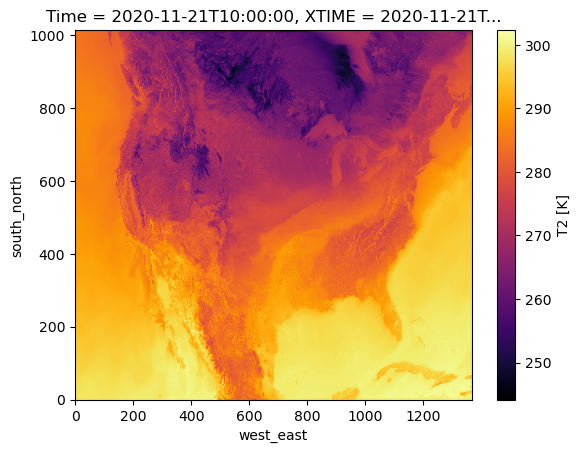

CPU times: user 713 ms, sys: 37.3 ms, total: 750 ms
Wall time: 867 ms


In [19]:
%%time

# pick a date and time
desired_time = "2020-11-21T10"
ds.sel(Time=desired_time,method='nearest').plot(cmap='inferno')
plt.show()

#### Read in a whole month of data for one variable

In [20]:
%%time 
start_date = "2020-10-01T00"
end_date = "2020-11-30T00"
monthly_data = ds.sel(Time=slice(start_date, end_date))
# compute mean 
monthly_mean = monthly_data.mean('Time').compute()

CPU times: user 1min 4s, sys: 8.76 s, total: 1min 12s
Wall time: 1min 22s


##### Load the values of a whole month into memory 

In [21]:
%%time 
xr_ds = monthly_data.compute()

CPU times: user 3min 6s, sys: 29.2 s, total: 3min 35s
Wall time: 4min 3s


### Plot the monthly mean 

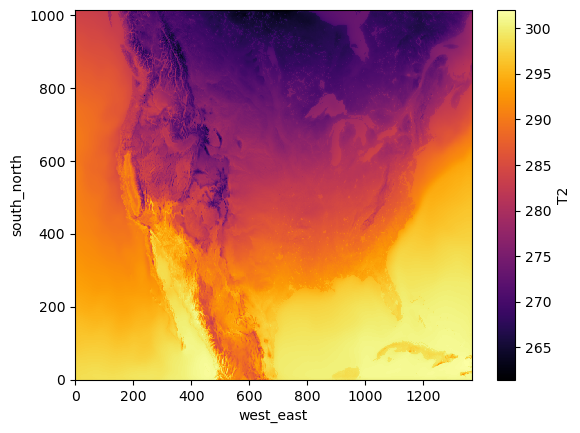

CPU times: user 516 ms, sys: 20 ms, total: 536 ms
Wall time: 497 ms


In [110]:
%%time
monthly_mean.plot(cmap='inferno')
plt.show()

## Load multiple years instead (e.g. for timeseries analyses)

You can subset the catalogue for only a period, to see what entries you get. This might be useful, if you look for overlapping periods with other datasets. 

In [13]:
# Define your list of start dates 
start_year = 2000
end_year = 2020
years = np.arange(start_year, end_year + 1)

# get the catalogue for all years
start_dates = [f'{year}-10-01' for year in years]
multiple_years = cat_temp.search(start_time=start_dates)
multiple_years 

,unique
path,20
variable,1
format,1
short_name,1
long_name,0
units,1
start_time,20
end_time,20
level,0
level_units,0


However, creating an xarray dataset from all 20 years of hourly data is also quite extensive for the memory. So instead, let's go through each entry and extract the necessary data for the timeseries. This still takes some time, because we basically take values from each file, but it is more efficient than e.g. xr.open_mfdataset() or opening each file with xarray dataset. However, for long timeseries, you also might consider non-Python based tools such as [NCO](https://nco.sourceforge.net/nco.pdf). 

In [14]:
# Define the variable and location
variable = "T2"

lats = ds['XLAT'].isel(Time=0).values
lons = ds['XLONG'].isel(Time=0).values
target_lat = 40.01499
target_lon = -105.27055

# get the indices for the location, e.g. Boulder
distance = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)
i, j = np.unravel_index(distance.argmin(), distance.shape)

In [15]:
# Years to process
years = range(2000, 2010)
monthly_means = []

for year in years:
    print(f"Processing {year}...")
    
    # catalogue for one year 
    cat = col.search(
        variable=variable,
        start_time=f"{year}-10-01"
    )
    
    # skip, iff no matching entries
    if len(cat.df) == 0:
        continue
    
    # load ds lazily 
    dset = cat.to_dataset_dict(aggregate=True)
    ds = list(dset.values())[0]
    
    # select location
    ts = ds[variable].isel(south_north=i, west_east=j).chunk({'Time': -1})
    # compute the monthly mean and append 
    monthly_mean = ts.resample(Time='1MS').mean().compute()
    monthly_means.append(monthly_mean)

# entire timeseries over 20 years 
all_monthly = xr.concat(monthly_means, dim="Time")

Processing 2000...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2001...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2002...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2003...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2004...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2005...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2006...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2007...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2008...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


Processing 2009...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


#### Timeseries plot 

In [16]:
all_monthly

<xarray.DataArray 'T2' (Time: 120)> Size: 480B
array([284.63693, 273.17282, 271.58536, 272.5231 , 272.24625, 277.7446 ,
       283.93204, 288.89108, 296.4048 , 299.6552 , 297.6402 , 293.77902,
       285.28284, 279.84912, 273.7511 , 272.4954 , 273.49667, 274.99524,
       284.71378, 288.62192, 297.75302, 300.66684, 296.67514, 292.34723,
       281.6112 , 276.32642, 274.92346, 276.2253 , 270.70828, 278.0107 ,
       284.53342, 289.62274, 292.93265, 301.31107, 298.42468, 291.07297,
       287.8117 , 275.6275 , 274.2466 , 273.47552, 272.636  , 281.4293 ,
       283.1979 , 290.68665, 293.0135 , 296.34344, 294.86624, 292.3208 ,
       285.0646 , 276.1261 , 274.45874, 274.78766, 275.98236, 278.16354,
       283.1899 , 289.3014 , 294.4689 , 300.57822, 296.75504, 294.02893,
       285.77005, 279.92944, 271.8223 , 276.11426, 273.32132, 276.22507,
       285.34415, 290.5942 , 297.58282, 299.24542, 296.7825 , 289.86407,
       283.99878, 278.56464, 273.50476, 269.84885, 274.31223, 281.2158 ,
       281.84814, 289.7414 , 296.10034, 300.02762, 298.33408, 293.45914,
       286.44623, 278.84875, 270.01663, 271.3817 , 273.62036, 277.5895 ,
       281.66586, 287.96695, 294.77466, 299.73294, 296.53613, 291.32977,
       285.3435 , 280.0389 , 271.20404, 273.65674, 276.12738, 278.96948,
       281.77176, 289.36755, 293.11493, 297.8113 , 297.07483, 292.22742,
       279.64813, 279.38132, 268.71933, 273.65344, 271.4167 , 278.0007 ,
       282.69238, 286.8766 , 296.3552 , 298.84015, 298.1797 , 294.60526],
      dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 960B 2000-10-01 2000-11-01 ... 2010-09-01
Attributes:
    description:  TEMP at 2 M
    stagger:       
    units:        K

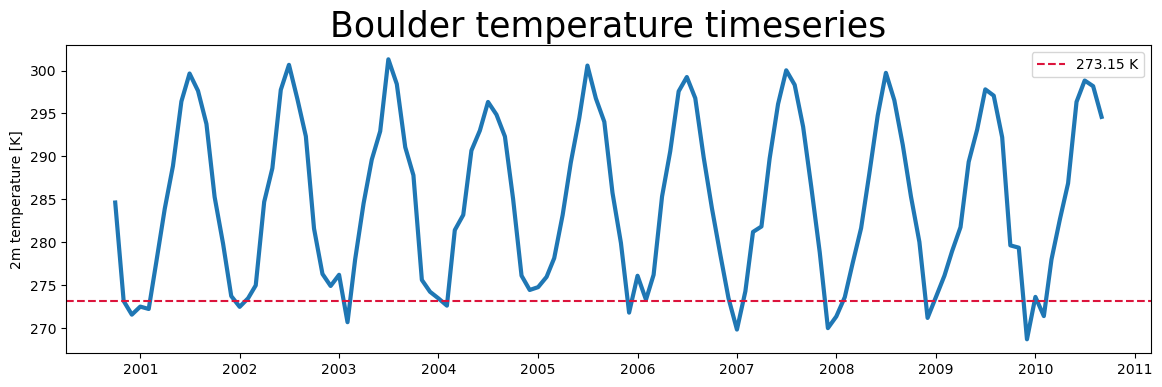

In [23]:
plt.figure(figsize = (14,4))
plt.plot(all_monthly.Time, all_monthly, lw = 3.0)
plt.ylabel('2m temperature [K]')
plt.axhline(273.15, color='crimson', linestyle='--', label='273.15 K')
plt.title('Boulder temperature timeseries', fontsize = 25 )
plt.legend()
plt.show()

In [25]:
# finally, close the PBS cluster, when you are done (this ends your submitted ask jobs) 
cluster.close()